<a href="https://colab.research.google.com/github/nbeaudoin/PyTorch-marathon/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network classification with PyTorch

Tutorial source: https://www.youtube.com/watch?v=V_xro1bcAuA&t=24452s

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1,000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
# make a Dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                         "X2": X[:, 1],
                         "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


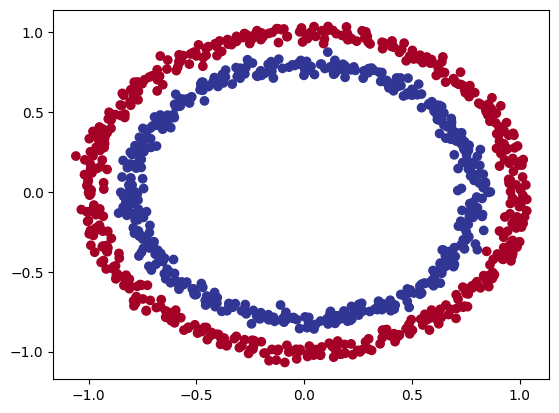

In [6]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check inputs and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Values for one sample of y: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Values for one sample of y: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
import torch
torch.__version__

'2.1.0+cu118'

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [16]:
n_samples

1000

## 2. Building a model

Let's build a model to classify the blue and red dots

To do so, we want to:
1. Setup device agnostic code so our code wil run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [17]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:
1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation)
4. Instantiate an instance of our model class and send it to our target `device`

In [18]:
X_train.shape

torch.Size([800, 2])

In [19]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [20]:
# 1. Construct a model that subclassess nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers for shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) ## takes in 2 features and upscales 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) ## takes in 5 features from previous layer and outputs a single layer

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) ## x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0



CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
device

'cuda'

In [22]:
# Put the model on GPU
next(model_0.parameters()).device

device(type='cuda', index=0)

In [23]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

`nn.Sequential` implements most of the the Neural Network for you. When you have more complex operations it is important to know how to build your own subclass. The subclass can extend to handl emuch more complexity.

In [24]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1160,  0.2752],
                      [-0.3078, -0.1140],
                      [-0.5207, -0.3406],
                      [ 0.2511,  0.5567],
                      [ 0.6526, -0.4365]], device='cuda:0')),
             ('0.bias',
              tensor([-0.1374,  0.5047, -0.3982, -0.1456,  0.3702], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.4294, -0.3334, -0.1514,  0.1083,  0.2570]], device='cuda:0')),
             ('1.bias', tensor([0.4043], device='cuda:0'))])

The optimizer is going to change these parameters after backprop to get a better approximation

In [25]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device)) ## remember to move it to GPU

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10].round()}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

For example, for regression you might want MAE and MSE

For classification, you might want binary cross entropy or categorical cross entropy

As a reminder, the loss fucntion measures how *wrong* your predictions are

* For the loss function we're going to use `torch.nn.BCEwithLogitsLoss()`


In [26]:
# Setup the loss function
#loss_fn = nn.BCEWithLogitsLoss  ## BCELoss = requires inputs to have gone through the sigmoid activation function
nn.Sequential(
    nn.Sigmoid(),
    nn.BCELoss()
)
loss_fn = nn.BCEWithLogitsLoss() ## sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [27]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1160,  0.2752],
                      [-0.3078, -0.1140],
                      [-0.5207, -0.3406],
                      [ 0.2511,  0.5567],
                      [ 0.6526, -0.4365]], device='cuda:0')),
             ('0.bias',
              tensor([-0.1374,  0.5047, -0.3982, -0.1456,  0.3702], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.4294, -0.3334, -0.1514,  0.1083,  0.2570]], device='cuda:0')),
             ('1.bias', tensor([0.4043], device='cuda:0'))])

In [28]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

Need to build a training loop.

1. Forward pass
2. Calculate loss
3. Optimize zero grad
4. Loss backward (backprop)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -? prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probs by passing them to some kind of activation function (eg, sigmoid classication and softmax for multiclass classification).

Then we can convert our model's predicted probs to prediction labels by rounding them or taking the `argmax()`

In [29]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3005],
        [0.4713],
        [0.0381],
        [0.3741],
        [0.3321]], device='cuda:0')

In [30]:
y_test[:5]
## This is not the same format as ^^^

tensor([1., 0., 1., 0., 1.])

In [31]:
# Use the sigmoid act function on our model logits to turn into pred probs
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5746],
        [0.6157],
        [0.5095],
        [0.5925],
        [0.5823]], device='cuda:0')

For our prediction probability values, we need to perform a range-style ounding on them.

* y_pred_probs >= 0.5, `y=1` (class 1)
* y_pred_probs < 0.5, `y=0` (class 0)

In [32]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

### 3.2 Building a training and testing loop

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) ## turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), ## n.BCELoss expects prediction probabilities as input
  #                y_train)
  loss = loss_fn(y_logits, ## nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. loss.backward()
  loss.backward()

  #5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2. Cacluate test loss/accuracy
    test_loss = loss_fn(test_logits,
                         y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test accc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71023, Acc: 58.13% | Test loss: 0.71851, Test accc: 57.00%
Epoch: 10 | Loss: 0.70099, Acc: 54.37% | Test loss: 0.70902, Test accc: 49.00%
Epoch: 20 | Loss: 0.69726, Acc: 52.88% | Test loss: 0.70472, Test accc: 47.00%
Epoch: 30 | Loss: 0.69563, Acc: 51.62% | Test loss: 0.70247, Test accc: 47.00%
Epoch: 40 | Loss: 0.69481, Acc: 51.50% | Test loss: 0.70108, Test accc: 47.00%
Epoch: 50 | Loss: 0.69433, Acc: 50.75% | Test loss: 0.70009, Test accc: 47.00%
Epoch: 60 | Loss: 0.69402, Acc: 51.00% | Test loss: 0.69933, Test accc: 47.50%
Epoch: 70 | Loss: 0.69379, Acc: 51.12% | Test loss: 0.69871, Test accc: 47.00%
Epoch: 80 | Loss: 0.69362, Acc: 51.00% | Test loss: 0.69819, Test accc: 47.00%
Epoch: 90 | Loss: 0.69349, Acc: 51.00% | Test loss: 0.69775, Test accc: 47.00%


## 4. Make predictions and evaluate the model

From the metrics, it looks like our model isn't learning anything

In [34]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

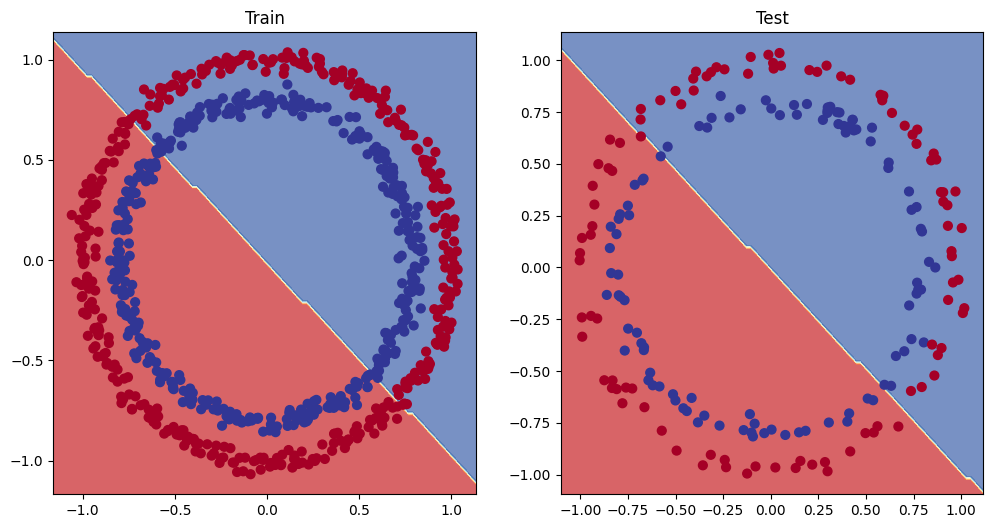

In [35]:
import numpy as np
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving the model (from a model perspective)

* Add more layers
* Add more hidden units
* Fit for longer
* Changnig the activation functions
* Change the learning rate
* Change the loss function

These options are all from our model's perspective because they deal directly with the model rather than the data.

Let's try making a better model!
* Add more hidden units
* Increase number of layers
* Increase epochs

In [36]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) ## this way levearges more speedups

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
# Create the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [38]:
# Write a training and evaliation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> predictions

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards (backprop)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate the loss
    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 47.00%
Epoch: 100 | Loss: 0.69369, Acc: 50.25 | Test loss: 0.69269, Test acc: 47.00%
Epoch: 200 | Loss: 0.69351, Acc: 50.12 | Test loss: 0.69282, Test acc: 47.00%
Epoch: 300 | Loss: 0.69339, Acc: 50.50 | Test loss: 0.69295, Test acc: 47.00%
Epoch: 400 | Loss: 0.69329, Acc: 50.38 | Test loss: 0.69309, Test acc: 47.00%
Epoch: 500 | Loss: 0.69322, Acc: 49.88 | Test loss: 0.69322, Test acc: 47.00%
Epoch: 600 | Loss: 0.69317, Acc: 49.50 | Test loss: 0.69335, Test acc: 47.00%
Epoch: 700 | Loss: 0.69313, Acc: 49.38 | Test loss: 0.69347, Test acc: 47.00%
Epoch: 800 | Loss: 0.69309, Acc: 50.00 | Test loss: 0.69358, Test acc: 47.00%
Epoch: 900 | Loss: 0.69307, Acc: 50.62 | Test loss: 0.69368, Test acc: 47.00%


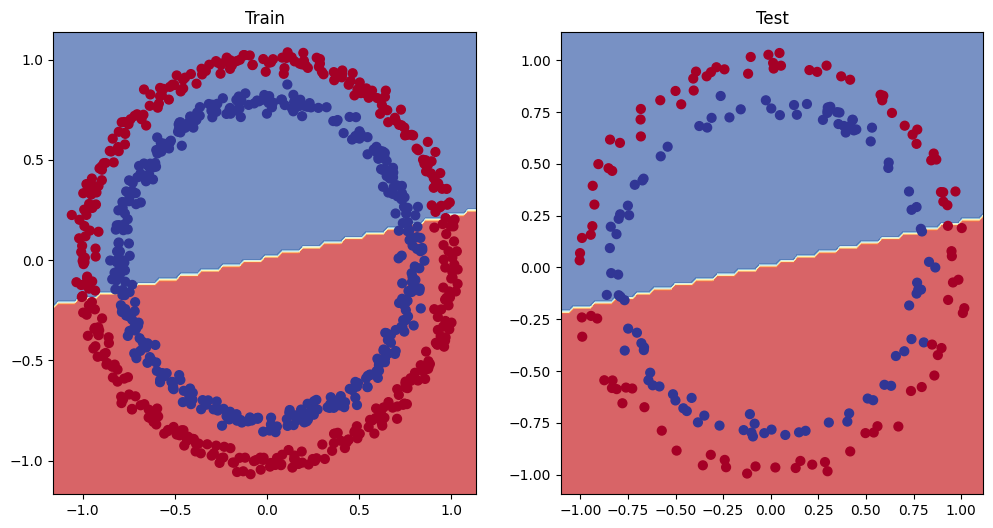

In [39]:
# Plot the decision boundary
import numpy as np
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5.1 Preparing the data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [40]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias ## linear regression formula without epsilon

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [41]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

In [42]:
# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

In [43]:
### Visualize!

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training_data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot preds if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label=predictions)

    # SHow the legned
    plt.legend(prop={"size": 14});

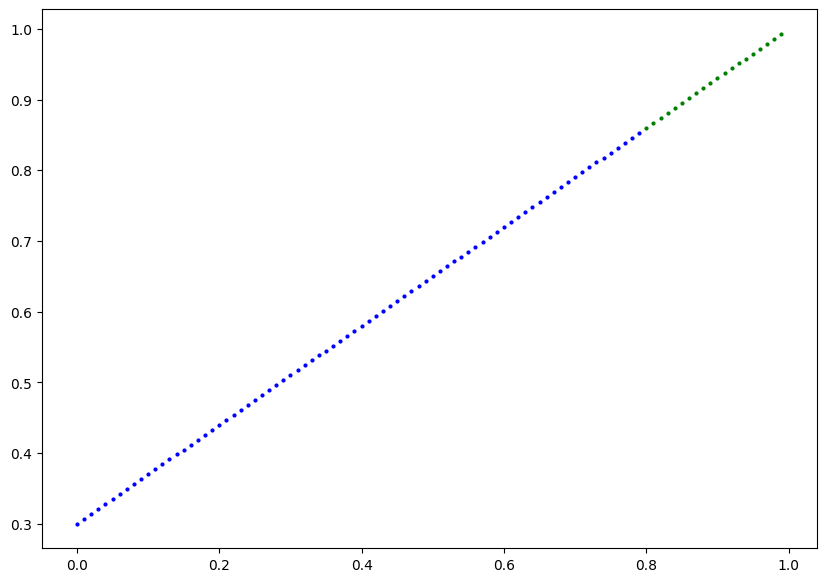

In [44]:
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [45]:
X_train_regression[0], y_train_regression[0]

(tensor([0.]), tensor([0.3000]))

In [46]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [47]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [48]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happening
  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.75986, Acc: 50.50 | Test loss: 0.91103, Test acc: 47.00%
Epoch: 100 | Loss: 0.02858, Acc: 50.50 | Test loss: 0.00081, Test acc: 47.00%
Epoch: 200 | Loss: 0.02533, Acc: 50.50 | Test loss: 0.00209, Test acc: 47.00%
Epoch: 300 | Loss: 0.02137, Acc: 50.50 | Test loss: 0.00305, Test acc: 47.00%
Epoch: 400 | Loss: 0.01964, Acc: 50.50 | Test loss: 0.00341, Test acc: 47.00%
Epoch: 500 | Loss: 0.01940, Acc: 50.50 | Test loss: 0.00387, Test acc: 47.00%
Epoch: 600 | Loss: 0.01903, Acc: 50.50 | Test loss: 0.00379, Test acc: 47.00%
Epoch: 700 | Loss: 0.01878, Acc: 50.50 | Test loss: 0.00381, Test acc: 47.00%
Epoch: 800 | Loss: 0.01840, Acc: 50.50 | Test loss: 0.00329, Test acc: 47.00%
Epoch: 900 | Loss: 0.01798, Acc: 50.50 | Test loss: 0.00360, Test acc: 47.00%


TypeError: ignored

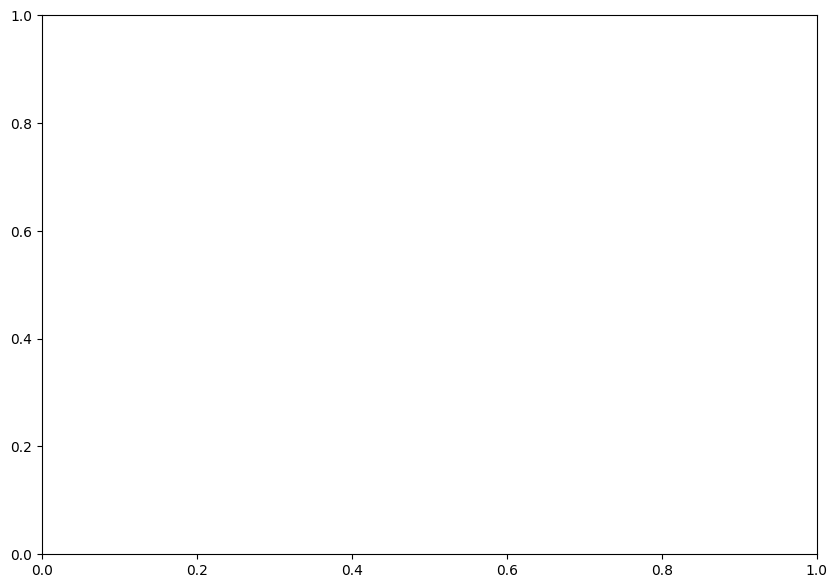

In [49]:
# Turn on evalutation model
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=y_preds)

Oh no! Error!!!

Remember, we need to put our tensors onto Numpy to use our Matplotlib function we created.

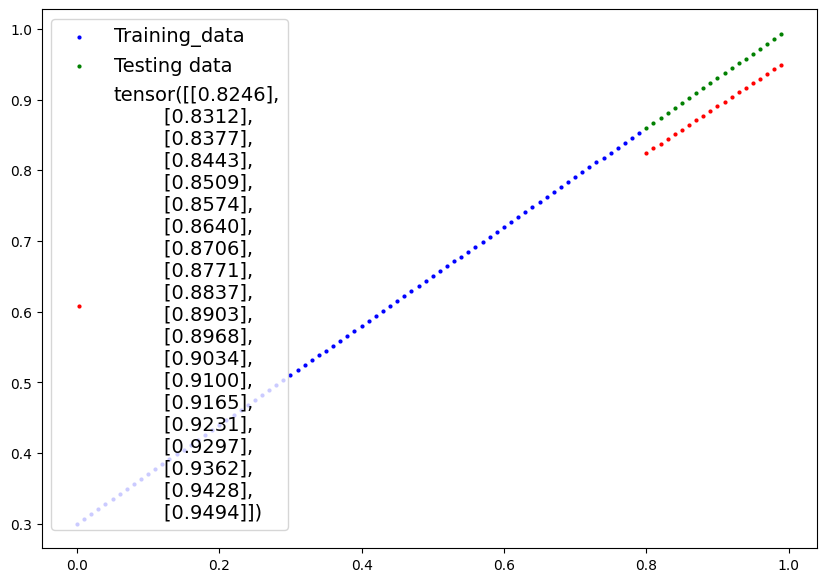

In [50]:
### Convert to CPU

# Turn on evalutation model
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

Or model has capacity to learn. So it isn't themodel, perhaps it is the data.

## 6. The missing pieice: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

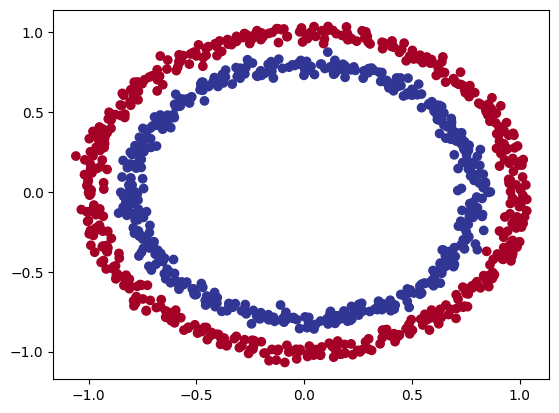

In [51]:
# Make and plot data
import matplotlib.pyplot
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [52]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

In [53]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


### 6.3 Training a model with non-linearity

In [54]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [55]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [56]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

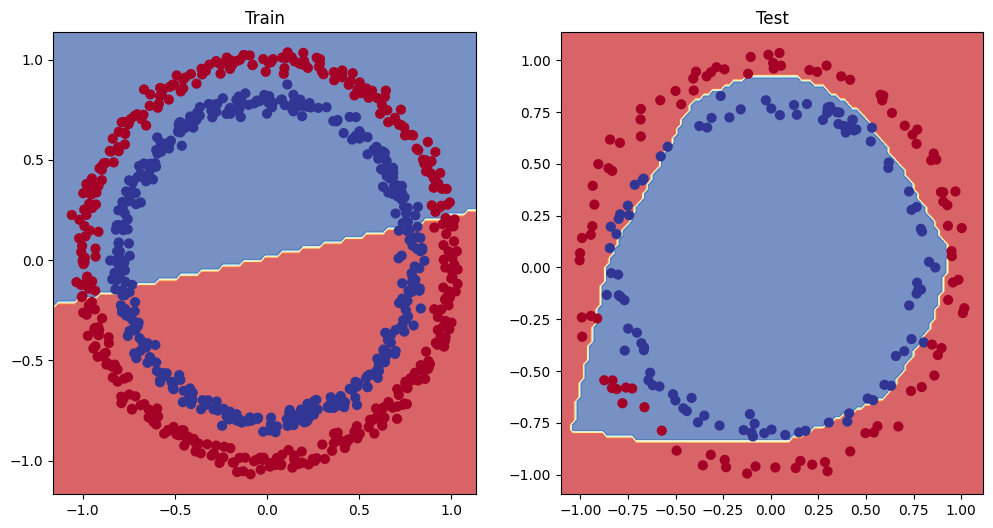

In [57]:
# Plot the decision boundary
### Remember: This function moves to CPU for Numpy
### Anything run after this needs to be converted again
import numpy as np
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Lots of stuff I already knew about activation functions

## 8. Putting it all together with a multi-class classification problem

### 8.1 Creating a toy multi-class dataset

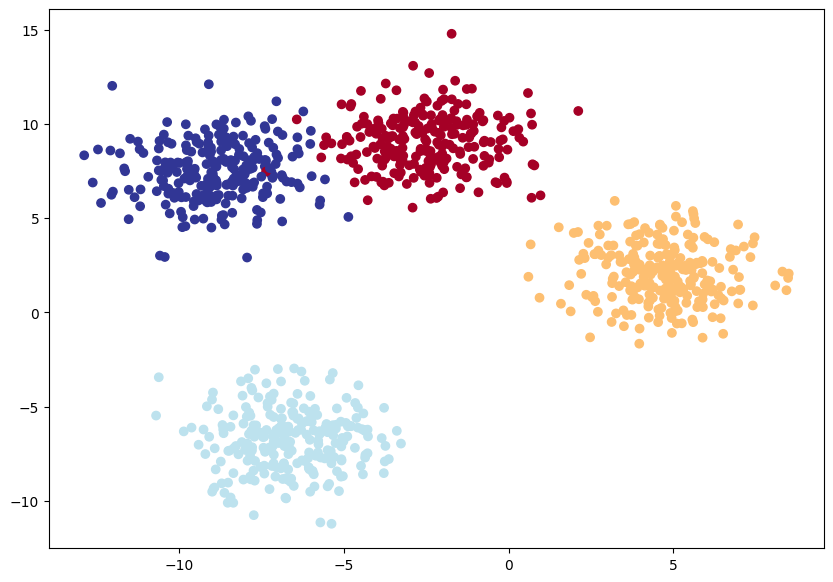

In [141]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameter for data creations
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, ## give the clusters some randomness
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [113]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [142]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Initializes multi-class classification model.

    Args:
      input_features (int): Number of input feautres to the model
      output_features (int): Number of outputs features (number of output classes)
      hidde_units (int): NUmber of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [115]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [116]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [143]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probs for a multi-class PyTorch model

In order to evaluate, test and train our model we need to convert our model utputs to (logits) to prediction probs and then to prediction labels

In [118]:
# Let's get some logits
model_4(X_blob_test)

RuntimeError: ignored

Ahhhh error!

In [119]:
next(model_4.parameters()).device

device(type='cuda', index=0)

In [120]:
X_blob_test.device

device(type='cpu')

In [121]:
model_4.eval()
with torch.inference_mode():
  y_preds = model_4(X_blob_test.to(device))

y_preds[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]], device='cuda:0')

In [122]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

Not same format as our test data

In [136]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [124]:
# Convert our model's prediction probs to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1) ## sum of rows is dim=1 (dim=0 is sum of cols)

In [125]:
y_preds, y_blob_test

(tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
         2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
         3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
         1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
         2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
         2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
         2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
         1, 3, 2, 3, 3, 1, 2, 3], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
         2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
         0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
         3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

Error Note: As another example, several loss functions like CrossEntropyLoss require that the target should be torch LongTensor. So before doing operations, make sure that your input Tensor types match the function definitions.

For FloatTensor, you can do math operations (multiplication, addition, division etc.) with a scalar of type int or float. But for LongTensor, you can only do math operation with int scalar but not float.

In [144]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.sigmoid(y_logits).argmax(dim=1)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      test_logits = model_4(X_blob_test)
      test_pred = torch.sigmoid(test_logits).argmax(dim=1)

      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Accuracy: 40.38% | Test Loss: 1.07554, Test Accuracy: 48.00%
Epoch: 100 | Loss: 0.03312, Accuracy: 99.25% | Test Loss: 0.02433, Test Accuracy: 99.50%
Epoch: 200 | Loss: 0.02657, Accuracy: 99.25% | Test Loss: 0.01651, Test Accuracy: 99.50%
Epoch: 300 | Loss: 0.02503, Accuracy: 99.25% | Test Loss: 0.01440, Test Accuracy: 99.50%
Epoch: 400 | Loss: 0.02427, Accuracy: 99.25% | Test Loss: 0.01335, Test Accuracy: 99.50%
Epoch: 500 | Loss: 0.02377, Accuracy: 99.25% | Test Loss: 0.01269, Test Accuracy: 99.50%
Epoch: 600 | Loss: 0.02339, Accuracy: 99.25% | Test Loss: 0.01218, Test Accuracy: 99.50%
Epoch: 700 | Loss: 0.02307, Accuracy: 99.25% | Test Loss: 0.01179, Test Accuracy: 99.50%
Epoch: 800 | Loss: 0.02279, Accuracy: 99.25% | Test Loss: 0.01147, Test Accuracy: 99.50%
Epoch: 900 | Loss: 0.02253, Accuracy: 99.25% | Test Loss: 0.01120, Test Accuracy: 99.50%


### 8.6 Making predictions

In [145]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_preds = model_4(X_blob_test.to(device))

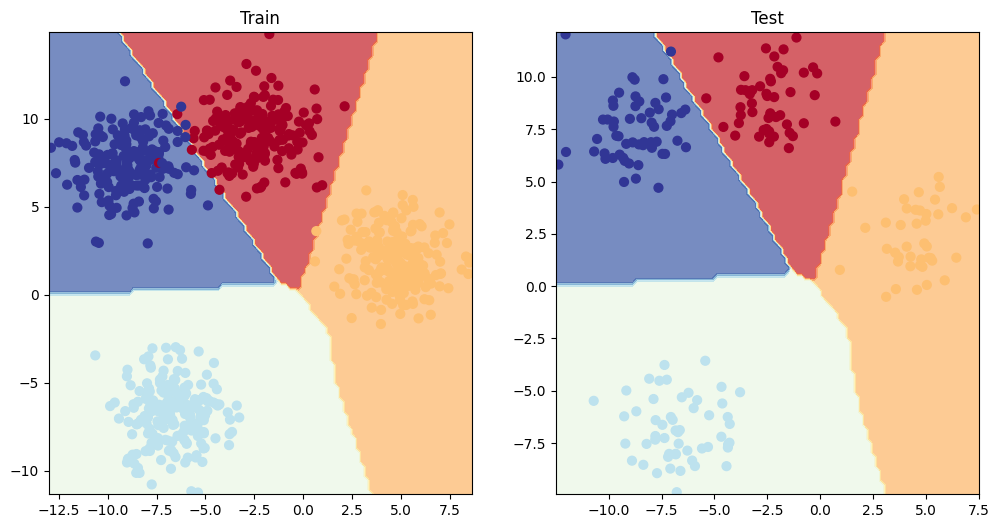

In [146]:
# Plot the decision boundary
### Remember: This function moves to CPU for Numpy
### Anything run after this needs to be converted again
import numpy as np
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics

* Accuracy
* Precision
* Recall
* F1
* Confusion matric
* Classication Report

In [147]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.8 MB/s eta 0:00:00


In [156]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calc accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')